In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import nltk
import numpy as np
import re
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.0f}'.format

In [3]:
df = pd.read_csv('datasets/oal_dt_dataset.csv', 
                 names=['doi', 'pm_grouptype', 'type', 'abstract', 'title', 'page', 'author_count',
                          'has_license', 'is_referenced_by_count',
                          'references_count', 'has_funder'],
                 dtype={'doi': str,
                        'pm_grouptype': str,
                        'type': str,
                        'abstract': str,
                        'title': str,
                        'page': str,
                        'author_count': int,
                        'has_license': int,
                        'is_referenced_by_count': int,
                        'references_count': int,
                        'has_funder': int
                 }, sep=',', quotechar='"', header=0, nrows=1000000)

In [4]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder
0,10.1001/2012.jama.10425,Journal_Article,research_discourse,NaN,A Path to Wholeness,985,4,0,1,0,0
1,10.1001/2012.jama.10452,Journal_Article,research_discourse,NaN,Worries,873,1,0,1,0,0
2,10.1001/2012.jama.10500,News,editorial_discourse,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0
3,10.1001/2012.jama.10931,Editorial,editorial_discourse,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0
4,10.1001/2012.jama.10939,News,editorial_discourse,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0


In [5]:
def page_counter(page_str):
    page_int = 1
    if '-' in str(page_str):
        try:
            page_str = re.sub('[^\d-]', '', page_str)
            page_int = int(abs(eval(page_str)))
            if page_int > 5000:
                page_int = 5000
        except:
            pass
        
    return page_int

In [6]:
df['page_count'] = df.page.apply(page_counter)
df['page_count'] = df['page_count'].astype(int)

In [7]:
df['title_word_length']  = df['title'].str.split().str.len()
df['abstract_word_length']  = df['abstract'].str.split().str.len()

In [8]:
df['title_string_length']  = df['title'].str.len()
df['abstract_string_length']  = df['abstract'].str.len()

In [9]:
def has_abstract(abstract_str):
    if pd.isna(abstract_str):
        return 0
    else:
        return 1

In [10]:
df['has_abstract'] = df.abstract.apply(has_abstract)
df['has_abstract'] = df['has_abstract'].astype(int)

In [11]:
df['title_string_length'] = df['title_string_length'].fillna(0)
df['abstract_string_length'] = df['abstract_string_length'].fillna(0)
df['title_word_length'] = df['title_word_length'].fillna(0)
df['abstract_word_length'] = df['abstract_word_length'].fillna(0)

In [12]:
df = df[df['type'] != 'not assigned']
df['type'] = df['type'].replace(to_replace='research_discourse', value=1)
df['type'] = df['type'].replace(to_replace='editorial_discourse', value=0)
df['type'] = df['type'].astype(int)
df = df.reset_index(drop=True)

In [13]:
X = df[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract']].values
y = df[['type']].values.ravel()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

## LogisticRegression

In [15]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.76      0.61      0.67     19804
 research_discourse       0.97      0.98      0.97    229788

           accuracy                           0.95    249592
          macro avg       0.86      0.80      0.82    249592
       weighted avg       0.95      0.95      0.95    249592



## OpenAlex

In [17]:
df_oal_test = pd.read_csv('datasets/oal_doctype_testset.csv')
df_oal_test = df_oal_test[df_oal_test['oaltype'] != 'not assigned']
df_oal_test = df_oal_test.reset_index(drop=True)

In [18]:
df_oal_test = df[['doi', 'type']].merge(df_oal_test, on=['doi'])

In [19]:
df_oal_test['type'] = df_oal_test['type'].replace(to_replace=1, value='research_discourse')
df_oal_test['type'] = df_oal_test['type'].replace(to_replace=0, value='editorial_discourse')

In [20]:
y_pm = df_oal_test[['type']].values.ravel()
y_oal = df_oal_test[['oaltype']].values.ravel()

In [21]:
print(classification_report(y_pm, y_oal, zero_division=1))

                     precision    recall  f1-score   support

editorial_discourse       0.99      0.06      0.12     79200
 research_discourse       0.93      1.00      0.96    918058

           accuracy                           0.93    997258
          macro avg       0.96      0.53      0.54    997258
       weighted avg       0.93      0.93      0.89    997258



## Scopus

In [22]:
df_scp_test = pd.read_csv('datasets/scp_doctype_testset.csv')
df_scp_test = df_scp_test[df_scp_test['scptype'] != 'not assigned']
df_scp_test = df_scp_test.reset_index(drop=True)

In [23]:
df_scp_test = df[['doi', 'type']].merge(df_scp_test, on=['doi'])

In [24]:
df_scp_test['type'] = df_scp_test['type'].replace(to_replace=1, value='research_discourse')
df_scp_test['type'] = df_scp_test['type'].replace(to_replace=0, value='editorial_discourse')

In [25]:
y_pm = df_scp_test[['type']].values.ravel()
y_scp = df_scp_test[['scptype']].values.ravel()

In [26]:
print(classification_report(y_pm, y_scp, zero_division=1))

                     precision    recall  f1-score   support

editorial_discourse       0.69      0.93      0.79     59480
 research_discourse       1.00      0.97      0.98    911611

           accuracy                           0.97    971091
          macro avg       0.84      0.95      0.89    971091
       weighted avg       0.98      0.97      0.97    971091



## Dummy

In [27]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X, y)

y_pred = dummy_clf.predict(X)
print(classification_report(y, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.08      0.08      0.08     79217
 research_discourse       0.92      0.92      0.92    919150

           accuracy                           0.85    998367
          macro avg       0.50      0.50      0.50    998367
       weighted avg       0.85      0.85      0.85    998367



In [28]:
## RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini', max_depth=None, max_features='sqrt', n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
 
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.72      0.70      0.71     19804
 research_discourse       0.97      0.98      0.98    229788

           accuracy                           0.95    249592
          macro avg       0.85      0.84      0.84    249592
       weighted avg       0.95      0.95      0.95    249592



In [30]:
importances = clf.feature_importances_

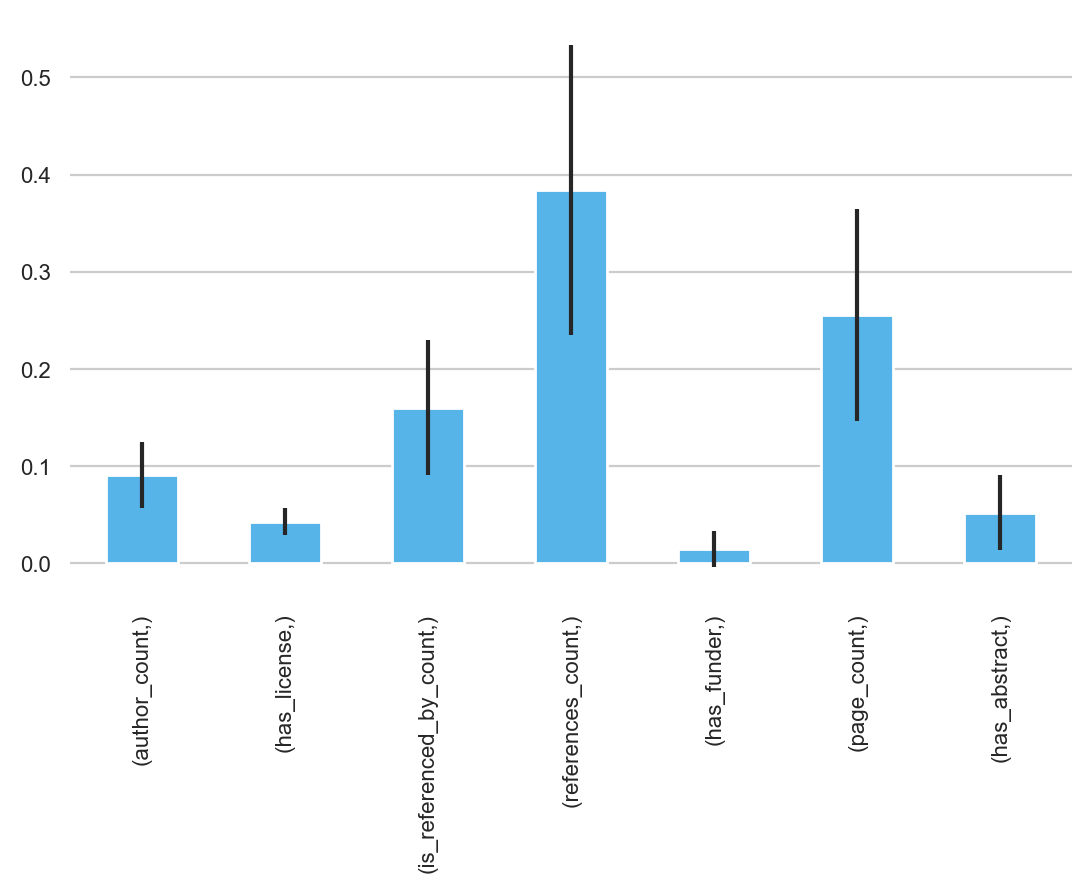

In [31]:
forest_importances = pd.Series(importances, index=[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract']])
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(5.5,4.5))
plt.box(False)
forest_importances.plot.bar(yerr=std, ax=ax, color='#56B4E9')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
fig.savefig('media/clf_importances.png', format='png', bbox_inches='tight', dpi=500)

## KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20, weights='uniform', leaf_size=30, p=1, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.71      0.73      0.72     19804
 research_discourse       0.98      0.97      0.98    229788

           accuracy                           0.96    249592
          macro avg       0.85      0.85      0.85    249592
       weighted avg       0.96      0.96      0.96    249592



In [33]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [34]:
from numpy import mean, std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.955 (0.001)


In [35]:
scores

array([0.95494004, 0.95480649, 0.9557814 , 0.95539411, 0.95532733,
       0.95463226, 0.9557541 , 0.95757042, 0.95516647, 0.95527331])